In [14]:
import pandas as pd
import numpy as np
import math
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore, t


from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import mutual_info_regression

from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score, mean_absolute_error
import os, pickle, csv
import statsmodels as sm   # contains good statistical tools for modeling

from statsmodels.stats.outliers_influence import variance_inflation_factor  # we will need vif for checking multicollinearity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import pandas.util.testing as tm

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
plt.style.use('ggplot')


In [15]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin','name']

df = pd.read_csv(uploaded,delim_whitespace=True,names=column_names)
df.drop(['name'], inplace=True, axis=1)

print(df.shape)
df.head(10)

(398, 8)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
6,14.0,8,454.0,220.0,4354.0,9.0,70,1
7,14.0,8,440.0,215.0,4312.0,8.5,70,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,1
9,15.0,8,390.0,190.0,3850.0,8.5,70,1


As can be seen data type of horsepower is object, let's check it's values


In [16]:
df.horsepower.unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

It has "?" value, which should be removed

In [17]:
df = df[df.horsepower != '?']
print('?' in df.horsepower)

False


In [18]:
df.horsepower = df.horsepower.astype('float')
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
year              int64
origin            int64
dtype: object

Checking for null values

In [19]:
df.isnull().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
year            False
origin          False
dtype: bool

In [20]:
#scale independent variables
columns = ['cylinders','displacement','horsepower','weight','acceleration','year','origin']

df[columns]=StandardScaler().fit_transform(df[columns])

print(df.shape)


(392, 8)


In [21]:
#apply z-score outlier treatment
z = np.abs(zscore(df['origin']))
df = df[ (z < 3) ]

z = np.abs(zscore(df['cylinders']))
df = df[ (z < 3) ]

z = np.abs(zscore(df['displacement']))
df = df[ (z < 3) ]

z = np.abs(zscore(df['horsepower']))
df = df[ (z < 3) ]

print(df.shape)

(387, 8)


## Visualize columns with histograms

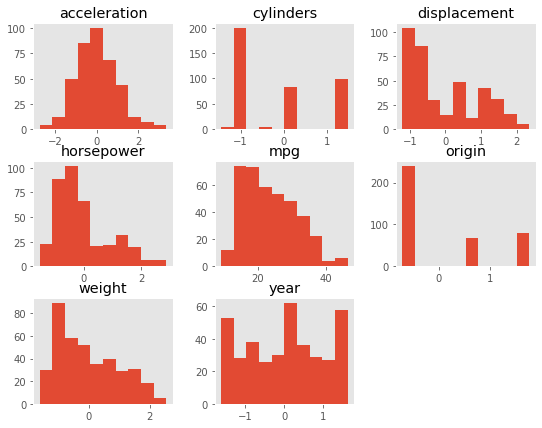

In [22]:
_ = df.hist(bins=10,figsize=(9,7),grid=False)


*   Acceleration feature has normal distribution and most of the cars have an acceleration 15m/s^2.
*   displacement, horsepower, weight is slightly right skewed
*   Most of the cars have 4 cylinders


Viewing Columns

In [23]:
X = df.drop(columns=['mpg'])
y = df['mpg'].to_numpy()
X.head(5)

,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,1.483947,1.077290,0.664133,0.620540,-1.285258,-1.625315,-0.716641
1,1.483947,1.488732,1.574594,0.843334,-1.466724,-1.625315,-0.716641
2,1.483947,1.182542,1.184397,0.540382,-1.648189,-1.625315,-0.716641
3,1.483947,1.048584,1.184397,0.536845,-1.285258,-1.625315,-0.716641
4,1.483947,1.029447,0.924265,0.555706,-1.829655,-1.625315,-0.716641


In [24]:
pd.DataFrame(data=[X.skew(),X.kurtosis()],index=['skewness','kurtosis'])

,cylinders,displacement,horsepower,weight,acceleration,year,origin
skewness,0.542020,0.680172,0.972767,0.533444,0.357604,0.006229,0.895431
kurtosis,-1.349136,-0.859466,0.330579,-0.777661,0.494826,-1.161029,-0.878073


Bivariate Analysis

In [25]:
numerical_features = df.select_dtypes(exclude=['object']).drop(['mpg'], axis=1).copy()
print(numerical_features.columns)

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'year', 'origin'],
      dtype='object')


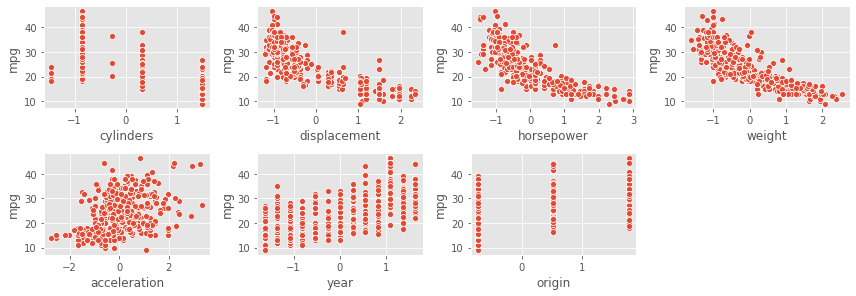

In [26]:
fig = plt.figure(figsize=(12,18))
for i in range(7):
    fig.add_subplot(9, 4, i+1)
    sns.scatterplot(numerical_features.iloc[:, i],df['mpg'])
plt.tight_layout()
plt.show()

Data Processing



Outliers


Notes on Outliers: According to the plots above, these are the features which appear to have outliers:



*   displacement
*   acceleration
*   horsepower







In [27]:
outliers = LocalOutlierFactor(n_neighbors=20).fit_predict(X)

target_out = LocalOutlierFactor(n_neighbors=20).fit_predict(y.reshape(-1, 1))

outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t


X,y=X[outliers],y[outliers]
X_2,y_2=X,y

print(X.shape)
y.shape

(367, 7)


(367,)

Checking correlation of features with mpg

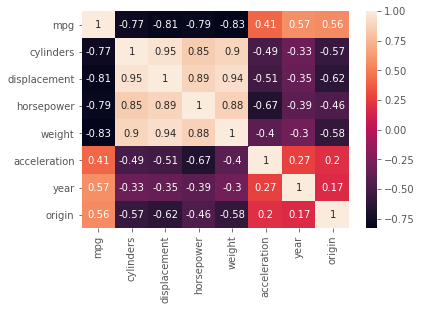

In [28]:
sns.heatmap(df.corr(),annot=True)

* According to heatmap, it can be noticed that cyliners, displacement, horsepower and weight have strong correlation with mpg. Meanwhile, acceleration, model year and origin have moderate correlation with target value. 
* There is a negative correlation between the displacement, weight, horsepower and cylinders. It shows that increase any of them, will result in mpg fall.
* Multicollinearity can be noticed between horsepower, displacement, cylinders and weight. It influences accuracy and performance of the model. To prevent it,some features should be droped.


Removing features with low variance, checking scores

In [30]:
X1 = sm.tools.add_constant(X) 

series1 = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],
                  index=X1.columns)

series1

const            1.030643
cylinders       11.579825
displacement    25.175819
horsepower      12.253353
weight          13.782386
acceleration     3.035697
year             1.180935
origin           1.778196
dtype: float64

It can be seen that dataset has multicollinearity as some features has variance inflation factor greater that 20. Cylinders, horsepower, weight and displacement have strong postitve correlations between each other. 

In [31]:
#Cylinders,displacement,weigth are the features with highest variance inflation factor. So they should be dropped.
X_new = X.drop(['displacement','horsepower'],axis=1)
X_new.shape

(367, 5)

In [32]:
X2 = sm.tools.add_constant(X_new)

series2 = pd.Series([variance_inflation_factor(X2.values,i) for i in range(X2.shape[1])],
                  index=X2.columns)

series2

const           1.003068
cylinders       5.973917
weight          5.312342
acceleration    1.387166
year            1.108111
origin          1.521723
dtype: float64

## Linear model tree

In [33]:
import requests


url_linreg = 'https://raw.githubusercontent.com/ankonzoid/LearningX/master/advanced_ML/model_tree/models/linear_regr.py'
url_modeltree='https://raw.githubusercontent.com/ankonzoid/LearningX/master/advanced_ML/model_tree/src/ModelTree.py'

r = requests.get(url_linreg, allow_redirects=True)
with open('linear_regr.py', 'wb') as file:
  file.write(r.content)

r = requests.get(url_modeltree, allow_redirects=True)
with open('ModelTree.py', 'wb') as file:
  file.write(r.content)


In [39]:
from ModelTree import ModelTree
from linear_regr import linear_regr

In [40]:
error_metric='neg_mean_absolute_error'


In [41]:
cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
param_grid = {
              "max_depth": [1,2,3,4,5,6,7,8],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45],
              # "search_type": ["greedy", "grid", "adaptive"],
              # "n_search_grid": [50,100,200]
              }

In [42]:
model = linear_regr()
model_tree = ModelTree(model, max_depth=4, min_samples_leaf=23,
                        search_type="greedy", n_search_grid=100)

In [43]:
grid = GridSearchCV(model_tree, param_grid,cv=cv_sets,n_jobs=4,scoring=error_metric)

In [44]:
try:
  X_new=X_new.to_numpy()
except:
  print('already converted to numpy')
try:
  y=y.to_numpy()
except:
  print('already converted to numpy')
grid = grid.fit(X_new, y)

print("Best Hyperparameters::\n{}".format(grid.best_estimator_))
X_new.shape

already converted to numpy
already converted to numpy
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001B5B41B2E50>, max_depth=1, min_samples_leaf=1, search_type=greedy, n_search_grid=100)


(367, 5)

In [45]:
lmt_t = grid.best_estimator_

[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

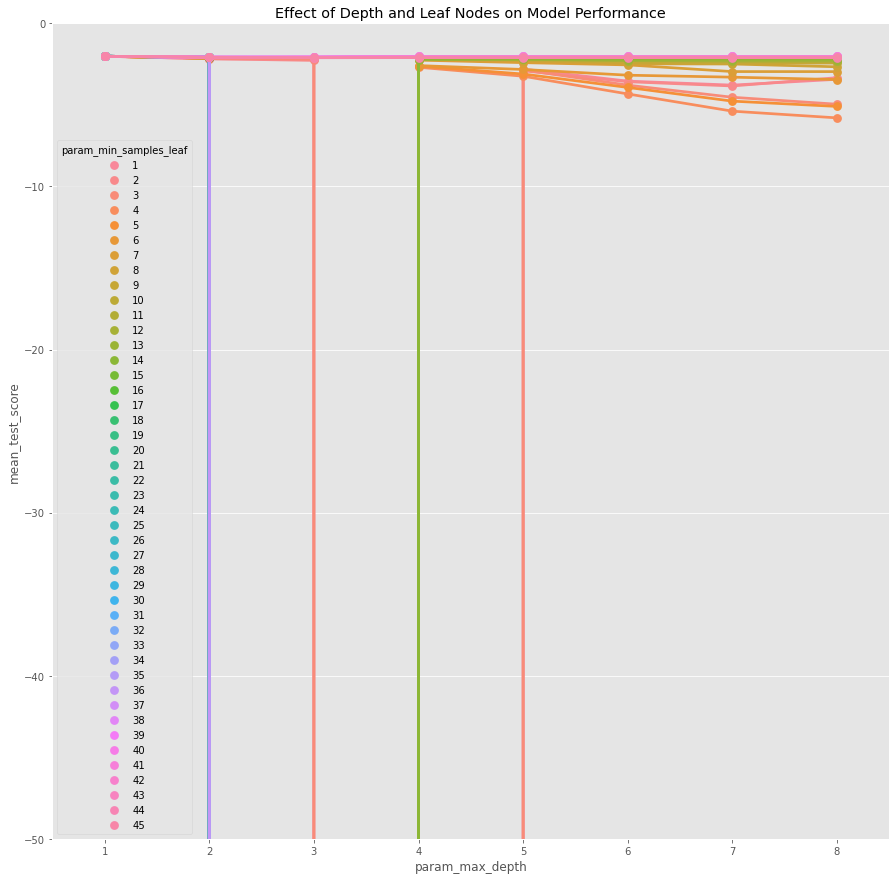

In [46]:
df = pd.DataFrame(data=grid.cv_results_)

fig,ax = plt.subplots(figsize=(15,15))
ax.set_ylim([-50,0])

sns.pointplot(data=df[['mean_test_score',
                           'param_min_samples_leaf',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_min_samples_leaf',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

In [47]:
def get_soc(D,f):
    return (2*D+1)+(2*f)

Before dropping features.

In [48]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)

In [49]:
print(X_new.shape)
# X_new=X_new.to_numpy()
mse = cross_val_score(lmt_t,X_new,y,cv=folds,scoring='neg_mean_squared_error')
mse=np.abs(np.mean(mse))
print("Mean Squared Error: {}".format(mse))
# rmse=math.sqrt(mse)
# print("Root Mean Squared Error: {}".format(rmse))
mae = cross_val_score(lmt_t,X_new,y,cv=folds,scoring='neg_mean_absolute_error')
mae = np.abs(np.mean(mae))
print("mean absolute error: {}".format(mae))
# r2 = cross_val_score(lmt_t,X_new,y,cv=folds,scoring='r2')
# r2 = np.abs(np.mean(r2))
# print("Overall model accuracy: {}".format(r2))
soc=get_soc(lmt_t.max_depth,X_new.shape[1])
print("SOC: {}".format(soc))

(367, 5)
Mean Squared Error: 8.736491740453808
mean absolute error: 2.0158289785722454
SOC: 13


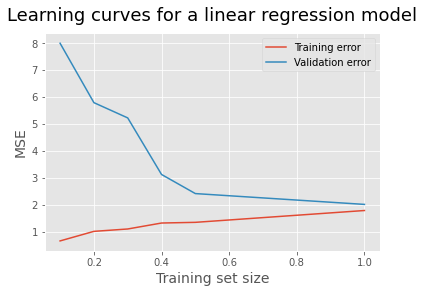

In [52]:
# X = StandardScaler().fit_transform(X)
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])
_,train_scores,validation_scores=learning_curve(lmt_t,X_new,y,cv=folds,train_sizes=train_sizes,scoring=error_metric)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
plt.title("Learning curve")

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.legend()
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

Training data fitted very well. Low gap between training error and validation error shows that model has low variance so, don't need to increase train size. Overall, it shows low bias and low variance.

After dropping features

In [53]:
mses = []
SOCs = []
maes = []
max_depth = []
print(X_new.shape)
# X=X.to_numpy()
# y=y.to_numpy()
for x in range(1,9):
  cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
  param_grid = {
                "max_depth": [x],
                "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]
  }  
  grid = GridSearchCV(model_tree, param_grid,cv=cv_sets,n_jobs=4,scoring=error_metric)
  grid = grid.fit(X_new, y)
  print("Best Hyperparameters::\n{}".format(grid.best_estimator_))

  lmt = grid.best_estimator_
  mse = cross_val_score(lmt,X_new,y,cv=folds,scoring='neg_mean_squared_error')
  mae = cross_val_score(lmt,X_new,y,cv=folds,scoring='neg_mean_absolute_error')

  mse=np.abs(np.mean(mse))
  mses.append(mse)
  mae=np.abs(np.mean(mae))
  maes.append(mae)
  soc=get_soc(x,X_new.shape[1])
  SOCs.append(soc)
  max_depth.append(x)
print(SOCs);
print(maes);
mses

(367, 5)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001B5B6CA85B0>, max_depth=1, min_samples_leaf=1, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001B5B6CA8550>, max_depth=2, min_samples_leaf=40, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001B5B6CBC4C0>, max_depth=3, min_samples_leaf=39, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001B5B6CD2670>, max_depth=4, min_samples_leaf=39, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001B5B6CA8A60>, max_depth=5, min_samples_leaf=39, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001B5B4694460>, max_depth=6, min_samples_leaf=39, search_type=greedy, n_s

[8.736491740453808,
 8.898067023543462,
 8.717964904717764,
 8.519879450203543,
 8.519879450203543,
 8.519879450203543,
 8.519879450203543,
 8.519879450203543]

In [73]:
arr_mse_min = 8.736
arr_mae_min = min(maes)
arr_soc_min = [13]
print("Lowest Mean Squared Error: {}".format(arr_mse_min))
print("Lowest Mean Absolute Error: {}".format(arr_mae_min))
print(SOCs)
print(mses)
print(maes)
arr_mse_min_soc = [8.736]					
arr_mae_min_soc = [2.015]
arr_soc_min_soc = [13]


Lowest Mean Squared Error: 8.736
Lowest Mean Absolute Error: 2.0158289785722454
[13, 15, 17, 19, 21, 23, 25, 27]
[8.736491740453808, 8.898067023543462, 8.717964904717764, 8.519879450203543, 8.519879450203543, 8.519879450203543, 8.519879450203543, 8.519879450203543]
[2.0158289785722454, 2.063910726867962, 2.058501376091859, 2.0215044565503586, 2.0215044565503586, 2.0215044565503586, 2.0215044565503586, 2.0215044565503586]


In [74]:
arr_mse_not_allowed = [ x for x in mses if x >= arr_mse_min*1.1 ]
arr_mae_not_allowed = [ x for x in maes if x >= arr_mae_min*1.1 ]
arr_mse_not_allowed, arr_mae_not_allowed

([], [])

In [75]:
arr_mse_not_allowed_soc = []
arr_mae_not_allowed_soc = []

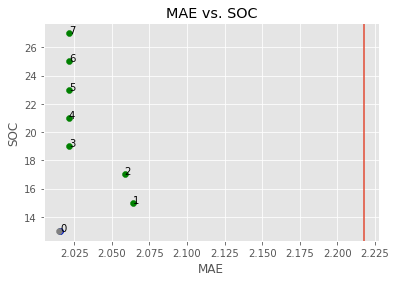

In [76]:
plt.title("MAE vs. SOC")

plt.scatter(maes, SOCs, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, arr_soc_min_soc, c='grey')
plt.axvline(x=arr_mae_min*1.1)
for i, txt in enumerate(mses):
    plt.annotate(i, (maes[i], SOCs[i]))
plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

In [77]:
data = { 'MSE': mses, 'MAE': maes, 'SOC': SOCs, 'max_depth ': max_depth, 'min_samples_leaf':min_samples_leaf }
df_2 = pd.DataFrame(data)
df_2

,MSE,MAE,SOC,max_depth,min_samples_leaf
0,8.736492,2.015829,13,1,1
1,8.898067,2.063911,15,2,40
2,8.717965,2.058501,17,3,39
3,8.519879,2.021504,19,4,39
4,8.519879,2.021504,21,5,39
5,8.519879,2.021504,23,6,39
6,8.519879,2.021504,25,7,39
7,8.519879,2.021504,27,8,39


In [78]:
X_new=X_2.drop(['displacement','horsepower'], axis=1)
X_new.shape

(367, 5)

In [79]:
df_header = X_new.columns.values  # header
header = list(df_header)
header

['cylinders', 'weight', 'acceleration', 'year', 'origin']

In [81]:
k=5
bestfeatures = SelectKBest(score_func=f_regression, k=k)
fit = bestfeatures.fit(X_new,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(header)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(k,'Score')) 

          Specs       Score
1        weight  867.901706
0     cylinders  590.570403
4        origin  160.957858
3          year  152.616564
2  acceleration   54.281072


In [84]:
X_orig=X_new.drop(['acceleration'], axis=1)
X_orig.shape

(367, 4)

In [85]:
cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
param_grid_2 = {
              "max_depth": [1,2,3,4,5,6],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35],
              # "search_type": ["greedy", "grid", "adaptive"],
              # "n_search_grid": [50,100,200]
              }
grid = GridSearchCV(model_tree, param_grid_2,cv=cv_sets,n_jobs=4,scoring=error_metric)
try:
  X_orig=X_orig.to_numpy()
except:
  print('already converted to numpy')
try:
  y=y.to_numpy()
except:
  print('already converted to numpy')
grid = grid.fit(X_orig, y)

print("Best Hyperparameters::\n{}".format(grid.best_estimator_))
lmt_t_2 = grid.best_estimator_
df2 = pd.DataFrame(data=grid.cv_results_)

already converted to numpy
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001B5B4018DC0>, max_depth=4, min_samples_leaf=30, search_type=greedy, n_search_grid=100)


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

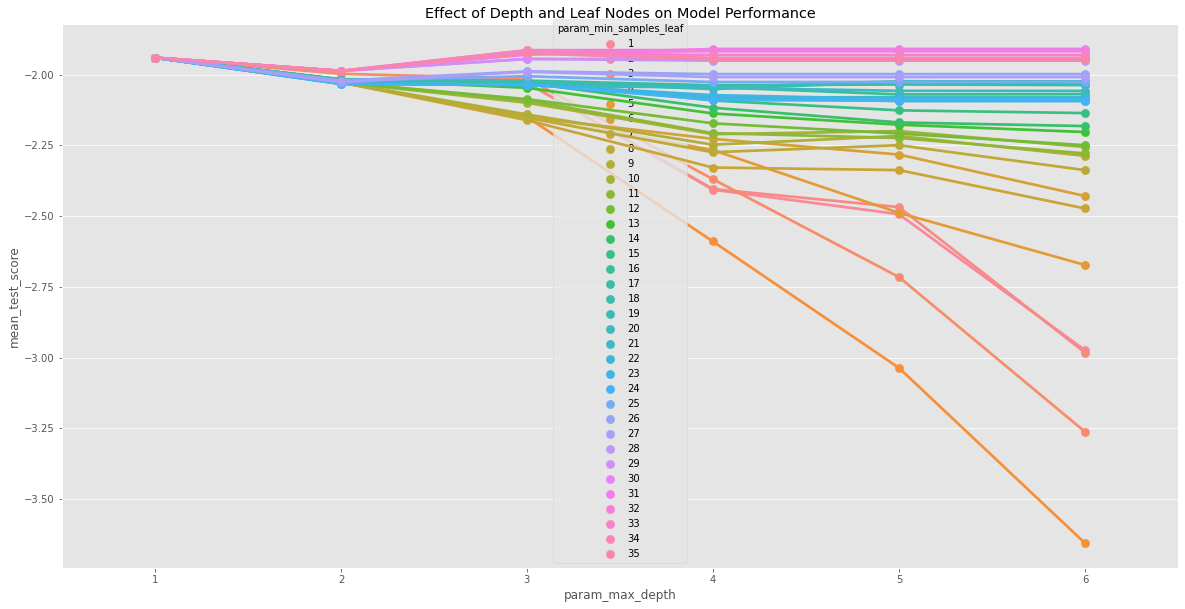

In [86]:
df2 = pd.DataFrame(data=grid.cv_results_)
fig,ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df2[['mean_test_score',
                           'param_min_samples_leaf',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_min_samples_leaf',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")
# X = StandardScaler().fit_transform(X)


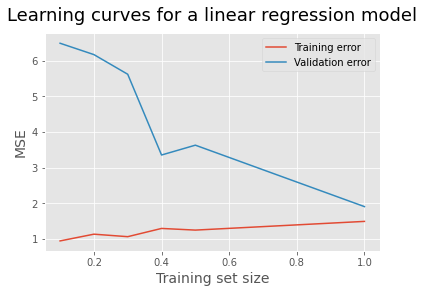

In [89]:
# X = StandardScaler().fit_transform(X)
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])
_,train_scores,validation_scores=learning_curve(lmt_t_2,X_orig,y,cv=folds,train_sizes=train_sizes,scoring=error_metric)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
plt.title("Learning curve")

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.legend()
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [90]:
folds = cv_sets

print(X_orig.shape)
# X=X.to_numpy()
mse = cross_val_score(lmt_t_2,X_orig,y,cv=folds,scoring='neg_mean_squared_error')
mse=np.abs(np.mean(mse))
print("Mean Squared Error: {}".format(mse))
rmse=math.sqrt(mse)
print("Root Mean Squared Error: {}".format(rmse))
mae = cross_val_score(lmt_t_2,X_orig,y,cv=folds,scoring='neg_mean_absolute_error')
mae = np.abs(np.mean(mae))
print("mean absolute error: {}".format(mae))
r2 = cross_val_score(lmt_t_2,X_orig,y,cv=folds,scoring='r2')
r2 = np.abs(np.mean(r2))
print("Overall model accuracy: {}".format(r2))
soc=get_soc(lmt_t_2.max_depth,X_orig.shape[1])
print("SOC: {}".format(soc))

(367, 4)
Mean Squared Error: 7.280028064598335
Root Mean Squared Error: 2.6981527133574805
mean absolute error: 1.9088648500009406
Overall model accuracy: 0.8505811960910471
SOC: 17


In [91]:
X_new=X_new.drop(['year'], axis=1)
X_new.shape

(367, 3)

already converted to numpy
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x000001B5B4152250>, max_depth=3, min_samples_leaf=35, search_type=greedy, n_search_grid=100)


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

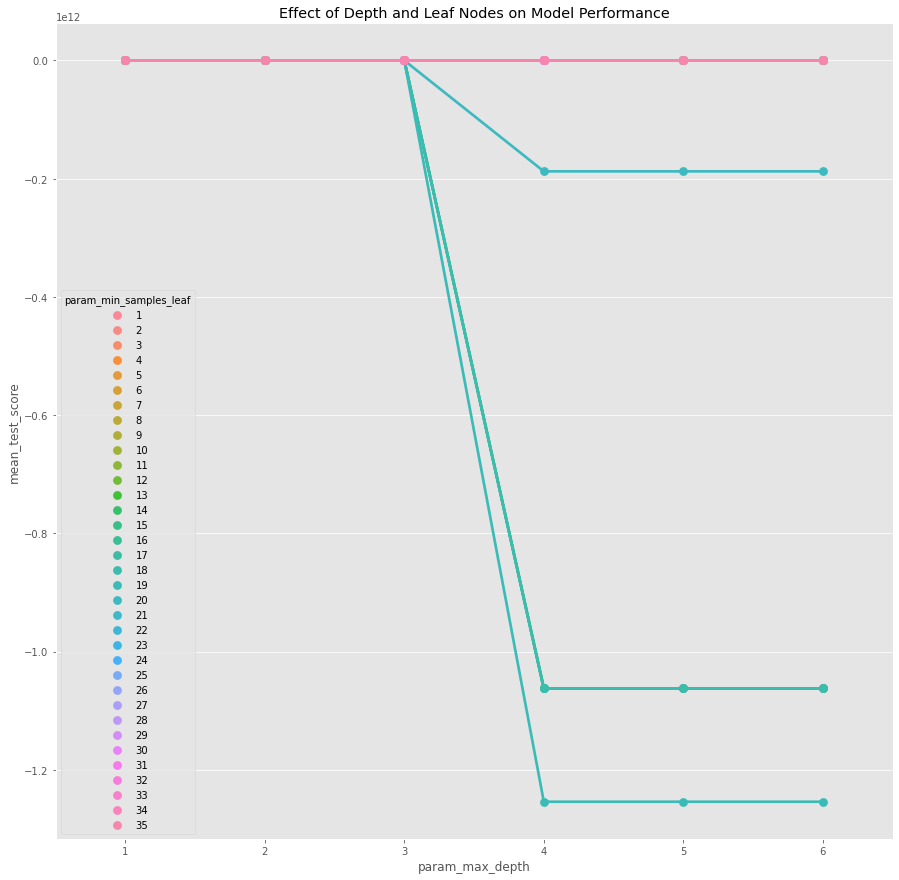

In [92]:
cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
param_grid_2 = {
              "max_depth": [1,2,3,4,5,6],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35],
              # "search_type": ["greedy", "grid", "adaptive"],
              # "n_search_grid": [50,100,200]
              }
grid = GridSearchCV(model_tree, param_grid_2,cv=cv_sets,n_jobs=4,scoring=error_metric)
try:
  X_new=X_new.to_numpy()
except:
  print('already converted to numpy')
try:
  y=y.to_numpy()
except:
  print('already converted to numpy')
grid = grid.fit(X_new, y)

print("Best Hyperparameters::\n{}".format(grid.best_estimator_))
lmt_t_3 = grid.best_estimator_
df2 = pd.DataFrame(data=grid.cv_results_)
df2 = pd.DataFrame(data=grid.cv_results_)
fig,ax = plt.subplots(figsize=(15,15))
sns.pointplot(data=df2[['mean_test_score',
                           'param_min_samples_leaf',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_min_samples_leaf',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")


In [93]:
folds = cv_sets

print(X_new.shape)
# X=X.to_numpy()
mse = cross_val_score(lmt_t_3,X_new,y,cv=folds,scoring='neg_mean_squared_error')
mse=np.abs(np.mean(mse))
print("Mean Squared Error: {}".format(mse))
rmse=math.sqrt(mse)
print("Root Mean Squared Error: {}".format(rmse))
mae = cross_val_score(lmt_t_3,X_new,y,cv=folds,scoring='neg_mean_absolute_error')
mae = np.abs(np.mean(mae))
print("mean absolute error: {}".format(mae))
soc=get_soc(lmt_t_3.max_depth,X_new.shape[1])
print("SOC: {}".format(soc))

(367, 3)
Mean Squared Error: 14.189735615202162
Root Mean Squared Error: 3.766926547625021
mean absolute error: 2.7620110922802494
SOC: 13


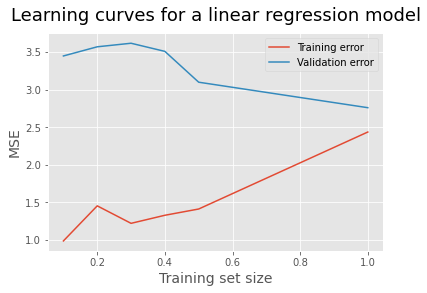

In [95]:
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])
_,train_scores,validation_scores=learning_curve(lmt_t_3,X_new,y,cv=cv_sets,train_sizes=train_sizes,scoring=error_metric)
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
plt.title("Learning curve")

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.legend()
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()